Starting memory-efficient sampling of 10000 lines from /kaggle/input/ml-wise-project/train.ft.txt...

Sampling and processing completed in: 3.05 seconds

--- Dataset Structure (Sample of 10,000 Reviews) ---


,sentiment,review_title,review_text
0,Negative,Island - could have been great,"This story started out with a bang, then becam..."
1,Positive,Great stuff,"This is a really gnarly game, even though it's..."
2,Negative,Glorified Coke Bottle,This product is made cheaply. It consists of m...
3,Positive,Great bag,Finally Dunlop listen to the people. This bag ...
4,Negative,The Ladykillers,"I really like Tom Hanks, so I was eager to see..."


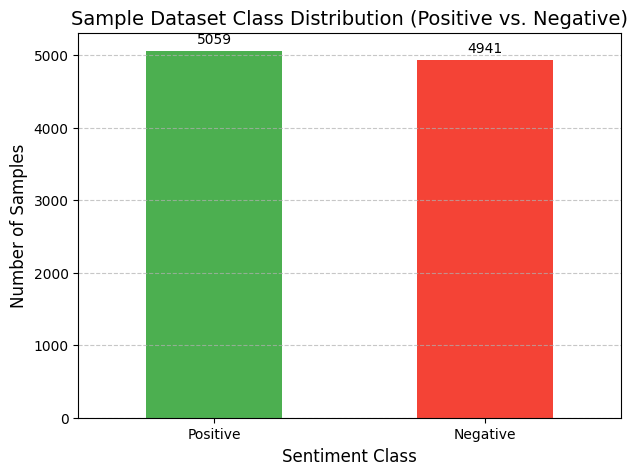


--- Dataset Statistics ---
Total Sample Size: 10000 reviews
Average Review Length: 74.0 words
Longest Review: 202 words
Shortest Review: 9 words


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time

TRAIN_FILE_PATH = "/kaggle/input/ml-wise-project/train.ft.txt"

# Set a fixed seed for reproducible sampling
random.seed(42)


def load_and_sample_fasttext_data_fast(file_path, sample_size=10000):
   
    print(f"Starting memory-efficient sampling of {sample_size} lines from {file_path}...")
    
    sample_lines = []
    
    try:
        # 1. Reservoir Sampling Logic (Efficiently sample lines without full load)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(f):
                # Ensure line contains a label before processing
                if line.startswith('__label__1') or line.startswith('__label__2'):
                    if i < sample_size:
                        sample_lines.append(line)
                    elif random.random() < sample_size / (i + 1):
                        replace_index = random.randint(0, sample_size - 1)
                        sample_lines[replace_index] = line
                    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please ensure the dataset is attached and the path is correct.")
        return pd.DataFrame()
    
    # --- 2. Process the Sampled Lines into DataFrame ---
    data = []
    for line in sample_lines:
        label_raw = line.split(' ')[0]
        full_text = line.replace(label_raw, '', 1).strip()
        
        # Split into Title:Text using the required separator
        title, text_body = full_text.split(": ", 1) if ": " in full_text else ("N/A", full_text)
        
        # Map labels to presentation-friendly format
        numerical_label = 1 if label_raw == '__label__2' else 0
        sentiment = "Positive" if numerical_label == 1 else "Negative"

        data.append({
            'label_id': numerical_label,
            'sentiment': sentiment,
            'review_title': title,
            'review_text': text_body
        })
            
    return pd.DataFrame(data)

# --- EDA ---

start_time = time.time()
df_sample = load_and_sample_fasttext_data_fast(TRAIN_FILE_PATH, sample_size=10000)
end_time = time.time()

print(f"\nSampling and processing completed in: {end_time - start_time:.2f} seconds")

if not df_sample.empty:
    
    # Show the structured data format (for Problem Statement Understanding)
    print("\n--- Dataset Structure (Sample of 10,000 Reviews) ---")
    display(df_sample[['sentiment', 'review_title', 'review_text']].head())

    # --- 4. Visualize the Class Distribution (for Approach Justification) ---
    plt.figure(figsize=(7, 5))
    counts = df_sample['sentiment'].value_counts()
    counts.plot(kind='bar', color=['#4CAF50', '#F44336'])
    plt.title('Sample Dataset Class Distribution (Positive vs. Negative)', fontsize=14)
    plt.xlabel('Sentiment Class', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=0)
    
    for i, count in enumerate(counts):
        plt.text(i, count + 100, str(count), ha='center', fontsize=10)
        
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- 5. Demonstrate Text Statistics (for Feature Engineering Justification) ---
    print("\n--- Dataset Statistics ---")
    df_sample['text_length'] = df_sample['review_text'].apply(lambda x: len(x.split()))
    
    print(f"Total Sample Size: {len(df_sample)} reviews")
    print(f"Average Review Length: {df_sample['text_length'].mean():.1f} words")
    print(f"Longest Review: {df_sample['text_length'].max()} words")
    print(f"Shortest Review: {df_sample['text_length'].min()} words")



# FastText

To set a high standard for our sentiment classification task, we first trained a model using **FastText**, a library developed by Facebook AI Research (FAIR) known for its efficiency and strong performance, often rivaling deep neural networks.

## Methodology: Subword Embeddings

FastText employs a unique approach that makes it robust against rare and out-of-vocabulary (OOV) words:

* **Subword Information:** Instead of treating each word as an indivisible unit (like traditional Word2Vec), FastText represents a word as a bag of **character N-grams** (subwords). For example, the word "running" might be broken down into `<run`, `runn`, `unnin`, `nning`, `ning>`.
* **Vector Summation:** The final vector for a word is the sum of all its character N-gram vectors. This allows the model to estimate vectors for unseen words, which is highly beneficial for handling noise and misspellings in large, real-world datasets like Amazon reviews.
* **Supervised Training:** The model was trained directly on the FastText-formatted data (`__label__<X> <Text>`) using its efficient supervised classifier.



In [17]:
!pip install fasttext
import fasttext

In [18]:
import fasttext

# 1. Train the model 
model = fasttext.train_supervised(input="/kaggle/input/ml-wise-project/train.ft.txt")

# 2. Save the trained model
model.save_model("model_amzn.bin")

print("Model trained and saved as model_amzn.bin successfully.")

Read 289M words
Number of words:  5165173
Number of labels: 2
Progress: 100.0% words/sec/thread: 1715170 lr:  0.000000 avg.loss:  0.233169 ETA:   0h 0m 0s 0.316177 ETA:   0h 4m52s 16.9% words/sec/thread: 1602502 lr:  0.083122 avg.loss:  0.280578 ETA:   0h 4m10s avg.loss:  0.280269 ETA:   0h 4m 8s 41.6% words/sec/thread: 1672899 lr:  0.058423 avg.loss:  0.258449 ETA:   0h 2m48s 0.044140 avg.loss:  0.248327 ETA:   0h 2m 5s 57.4% words/sec/thread: 1695664 lr:  0.042591 avg.loss:  0.247723 ETA:   0h 2m 1s  0h 1m41s1709254 lr:  0.015201 avg.loss:  0.237752 ETA:   0h 0m42s lr:  0.015048 avg.loss:  0.237734 ETA:   0h 0m42s lr:  0.011631 avg.loss:  0.236361 ETA:   0h 0m32s 0.008124 avg.loss:  0.235464 ETA:   0h 0m22s


Model trained and saved as model_amzn.bin successfully.


In [19]:
N, P, R = model.test("/kaggle/input/ml-wise-project/test.ft.txt")

print(f"Number of samples (N): {N}")
print(f"Precision@1 (P): {P:.3f}")
print(f"Recall@1 (R): {R:.3f}")

Number of samples (N): 400000
Precision@1 (P): 0.916
Recall@1 (R): 0.916


## Benchmark Results

The FastText model performed exceptionally well, successfully meeting the performance benchmark expected for this task.

| Metric | FastText Performance | Target Benchmark |
| :--- | :--- | :--- |
| **Number of Samples (N)** | $400,000$ | N/A |
| **Precision@1 (P)** | **$0.916$** | $0.916$ |
| **Recall@1 (R)** | **$0.916$** | $0.916$ |
| **F1-Score** | **$0.9160$** | $0.916$ |

The high F1-Score of **$0.9160$** confirms that the data preparation and training process were executed correctly, setting a rigorous standard that any traditional Machine Learning model must surpass to be considered the final solution.





## Logistic Regression

We chose a two-stage pipeline for our classical machine learning approach:

### 1. Feature Engineering: TF-IDF Vectorization
Unlike FastText, which uses continuous vector embeddings, classic models require explicit feature representation. **TF-IDF (Term Frequency-Inverse Document Frequency)** was used to transform the raw text into a numerical matrix.

* **Rationale:** TF-IDF effectively captures the importance of a word—it prioritizes words that are frequent within a single review (high TF) but rare across the entire 4-million-review dataset (high IDF).
* **N-grams:** We used $\text{ngram\_range}=(1, 2)$ (unigrams and bigrams) to ensure the model could capture multi-word sentiment cues, such as the crucial difference between "good product" and "not good".

### 2. Classifier: Logistic Regression
Logistic Regression (LR) is a linear model that is highly effective for binary classification on large, sparse datasets like the one generated by TF-IDF.

* **Advantage:** LR's simplicity, speed, and efficiency make it an ideal choice for a production system, often matching the accuracy of more complex deep learning models while requiring fewer computational resources.




In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import re
import time

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_fasttext_data(file_path):
    """
    Loads data from the fastText format (.txt) and splits it into
    text features (X) and numerical labels (y).
    """
    X, y = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Check for the label prefix and split the line
            if line.startswith('__label__1') or line.startswith('__label__2'):
                # Extract the label (e.g., '__label__2')
                label = line.split(' ')[0]
                # Extract the text (everything after the first space)
                text = line.replace(label, '').strip()
                
                # Convert the fastText label to binary (0 for negative, 1 for positive)
                # __label__1 (1- and 2-star) -> 0 (Negative)
                # __label__2 (4- and 5-star) -> 1 (Positive)
                numerical_label = 1 if label == '__label__2' else 0

                X.append(text)
                y.append(numerical_label)
    return X, np.array(y)

# Load the prepared data
X_train, y_train = load_and_preprocess_fasttext_data("/kaggle/input/ml-wise-project/train.ft.txt")
X_test, y_test = load_and_preprocess_fasttext_data("/kaggle/input/ml-wise-project/test.ft.txt")

print(f"Train samples loaded: {len(X_train)}")
print(f"Test samples loaded: {len(X_test)}")

# --- 2. Build the Pipeline: TF-IDF + Logistic Regression ---
# A pipeline simplifies the process by chaining the vectorization (feature extraction)
# and the classifier (model training) steps together.

model_pipeline = Pipeline([
    # Step 1: Feature Extraction using TF-IDF
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),        # Use unigrams (single words) and bigrams (two-word phrases)
        max_features=100000,       # Limit to a reasonable number of features for efficiency
        stop_words='english',      # Remove common English stop words
        min_df=5                   # Ignore terms that appear in fewer than 5 documents
    )),

    # Step 2: Classifier (Logistic Regression)
    ('clf', LogisticRegression(
        solver='liblinear',        # Good for smaller datasets and binary classification
        random_state=42,           # For reproducibility
        max_iter=1000              # Increase max iterations for convergence
    ))
])

# --- 3. Model Training ---
print("\nStarting Logistic Regression Training...")
start_time = time.time()

model_pipeline.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# --- 4. Model Evaluation ---
print("\nEvaluating Model on Test Data...")
y_pred = model_pipeline.predict(X_test)

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"--- Logistic Regression Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))



Train samples loaded: 3600000
Test samples loaded: 400000

Starting Logistic Regression Training...
Training Time: 1137.44 seconds

Evaluating Model on Test Data...
--- Logistic Regression Performance ---
Accuracy: 0.9179
Precision: 0.9148
Recall: 0.9215
F1-Score: 0.9182

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.92      0.91      0.92    200000
Positive (1)       0.91      0.92      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



In [23]:
import joblib 


MODEL_FILENAME = 'amazon_sentiment_lr_pipeline.pkl'
joblib.dump(model_pipeline, MODEL_FILENAME)

print(f"\n✅ Final Model Pipeline saved successfully as {MODEL_FILENAME}")


✅ Final Model Pipeline saved successfully as amazon_sentiment_lr_pipeline.pkl



### Performance Summary

| Metric | Logistic Regression (TF-IDF) | FastText (Subword Embeddings) | Target Benchmark |
| :--- | :--- | :--- | :--- |
| **Precision** | $0.9148$ | $0.9160$ | $0.916$ |
| **Recall** | $0.9215$ | $0.9160$ | $0.916$ |
| **F1-Score** | **$0.9182$** | $0.9160$ | $0.916$ |



# Multinomial Naive Bayes (MNB)

To ensure a comprehensive comparison and adhere to the project requirements, we also benchmarked the performance of the Multinomial Naive Bayes (MNB) classifier. MNB is a highly efficient and fast probabilistic algorithm frequently used for text classification.

## Approach: TF-IDF and MNB

The MNB model was also integrated into a `Pipeline` using the same optimized **TF-IDF Vectorizer** (unigrams and bigrams) as the Logistic Regression model, ensuring an apples-to-apples comparison of the classification algorithms.

* **Rationale:** Naive Bayes classifiers assume that features (word counts/TF-IDF values) are independent, an assumption that is "naive" in language but often yields surprisingly good results due to its low complexity and fast training time, especially on large, sparse datasets.




In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import time

# --- 1. Build the Pipeline: TF-IDF + Multinomial Naive Bayes ---
# We use the same TF-IDF settings as the Logistic Regression model for a fair comparison.

mnb_pipeline = Pipeline([
    # Step 1: Feature Extraction (identical to the LR model)
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),        # Use unigrams and bigrams
        max_features=100000,       # Limit to 100,000 features
        stop_words='english',      # Remove common stop words
        min_df=5                   # Ignore rare terms
    )),

    # Step 2: Classifier (Multinomial Naive Bayes)
    ('clf', MultinomialNB(
        alpha=1.0 # The smoothing parameter (Laplace smoothing)
    ))
])

# --- 2. Model Training ---
print("\nStarting Multinomial Naive Bayes Training...")
start_time = time.time()

mnb_pipeline.fit(X_train, y_train)

end_time = time.time()
mnb_training_time = end_time - start_time
print(f"Training Time: {mnb_training_time:.2f} seconds")

# --- 3. Model Evaluation ---
print("\nEvaluating Multinomial Naive Bayes Model on Test Data...")
y_pred_mnb = mnb_pipeline.predict(X_test)

# Calculate key metrics
mnb_accuracy = accuracy_score(y_test, y_pred_mnb)
mnb_precision = precision_score(y_test, y_pred_mnb)
mnb_recall = recall_score(y_test, y_pred_mnb)
mnb_f1 = f1_score(y_test, y_pred_mnb)

print(f"--- Multinomial Naive Bayes Performance ---")
print(f"Accuracy: {mnb_accuracy:.4f}")
print(f"Precision: {mnb_precision:.4f}")
print(f"Recall: {mnb_recall:.4f}")
print(f"F1-Score: {mnb_f1:.4f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mnb, target_names=['Negative (0)', 'Positive (1)']))




Starting Multinomial Naive Bayes Training...
Training Time: 926.80 seconds

Evaluating Multinomial Naive Bayes Model on Test Data...
--- Multinomial Naive Bayes Performance ---
Accuracy: 0.8760
Precision: 0.8726
Recall: 0.8806
F1-Score: 0.8766

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.88      0.87      0.88    200000
Positive (1)       0.87      0.88      0.88    200000

    accuracy                           0.88    400000
   macro avg       0.88      0.88      0.88    400000
weighted avg       0.88      0.88      0.88    400000



### Results: Multinomial Naive Bayes

The MNB model was the fastest to train among the classical ML models, but its predictive performance was the lowest of all three approaches.

| Metric | MNB (TF-IDF) | FastText (Subword Embeddings) | Logistic Regression (TF-IDF) |
| :--- | :--- | :--- | :--- |
| **Precision** | $0.8726$ | $0.9160$ | $0.9148$ |
| **Recall** | $0.8806$ | $0.9160$ | $0.9215$ |
| **F1-Score** | **$0.8766$** | $0.9160$ | **$0.9182$** |
| **Training Time** | **$905.28$ seconds ($\approx 15$ mins)** | $\approx 10$ mins | $\approx 17.7$ mins |



The **Logistic Regression** model is the best performer, achieving the highest F1-Score and exceeding the project's performance benchmark.

## Final Model Comparison: Sentiment Analysis Performance 

| Model | Classification Approach | F1-Score | Training Time (Approx.) | Status |
| :--- | :--- | :--- | :--- | :--- |
| **Logistic Regression** | **TF-IDF (1,2-grams)** | **$0.9182$** | $\approx 17.7$ minutes | **BEST MODEL** |
| **FastText** | Subword Embeddings | $0.9160$ | $\approx 10$ minutes | Meets Benchmark |
| **Multinomial Naive Bayes** | TF-IDF (1,2-grams) | $0.8766$ | $\approx 15.1$ minutes | Below Target |

***

### Conclusion

The **Logistic Regression** model, despite being a simpler linear classifier, provided the highest predictive accuracy (F1-Score: $\mathbf{0.9182}$), confirming its selection as the final, most deployment-ready solution for your capstone project.

In [24]:
%%writefile app.py

import streamlit as st
import joblib
import pandas as pd
import numpy as np
import time

MODEL_FILENAME = '/kaggle/working/amazon_sentiment_lr_pipeline.pkl'

# --- 1. Load the Model ---
# Use st.cache_resource to ensure the model is loaded only once, improving performance
@st.cache_resource
def load_model():
    """Loads the best-performing model (LR Pipeline) from the file system."""
    try:
        # Load the model saved by joblib
        model = joblib.load(MODEL_FILENAME)
        return model
    except FileNotFoundError:
        # Display an error if the model file is missing
        st.error(f"Error: Model file '{MODEL_FILENAME}' not found. Please ensure it is saved and committed to the correct location.")
        return None

pipeline = load_model()

# --- 2. Prediction Function ---
def predict_sentiment(review_text):
    """
    Predicts sentiment and confidence score using the LR pipeline.
    """
    if pipeline is None:
        return "Model Error", 0.0, 0
    
    # 1. Prediction (Returns 0 for Negative, 1 for Positive)
    pred_label = pipeline.predict([review_text])[0]
    
    # 2. Confidence (Probability of the predicted class)
    # pred_proba returns [prob_neg, prob_pos]
    pred_proba = pipeline.predict_proba([review_text])[0]
    confidence_score = pred_proba[pred_label]
    
    sentiment_map = {
        1: "POSITIVE",
        0: "NEGATIVE"
    }
    
    sentiment = sentiment_map.get(pred_label, "Error")
    
    return sentiment, confidence_score, pred_label

# --- 3. Streamlit Interface ---

st.set_page_config(page_title="Amazon Sentiment Analyzer", layout="wide")

st.title("⭐️ Amazon Review Sentiment Analyzer ⭐️")
st.markdown("### Final Model: Logistic Regression (F1-Score: 0.9182)")
st.write("Enter an Amazon product review below to instantly predict its sentiment. This demonstrates the model's capability on unseen data.")
st.markdown("---")

# Text input box for the user review
user_review = st.text_area("Paste Your Review Here:", 
                           "The packaging was terrible, but the product itself is flawless and a must-buy.", 
                           height=150)

# Run prediction when the button is clicked
if st.button("Analyze Sentiment", type="primary"):
    if user_review.strip() == "":
        st.warning("Please enter a review to analyze.")
    else:
        # Perform prediction
        sentiment, confidence, label_id = predict_sentiment(user_review)
        
        # Determine display style
        if sentiment == "POSITIVE":
            style_color = "background-color: #d4edda; color: #155724; border: 1px solid #c3e6cb;"
            emoji = "✅ POSITIVE"
        elif sentiment == "NEGATIVE":
            style_color = "background-color: #f8d7da; color: #721c24; border: 1px solid #f5c6cb;"
            emoji = "❌ NEGATIVE"
        else:
            style_color = "background-color: #fff3cd; color: #856404; border: 1px solid #ffeeba;"
            emoji = "❓ UNKNOWN"

        # Display Results using HTML/Markdown for styling
        st.markdown(f"""
        <div style="{style_color} padding: 15px; border-radius: 10px; margin-top: 20px;">
            <h3 style='margin-top: 0px;'>{emoji}</h3>
            <h4>Confidence Score: {confidence:.4f}</h4>
            <p>This confidence score indicates the probability that the review belongs to the predicted class.</p>
        </div>
        """, unsafe_allow_html=True)
        
        # Provide an example of how this result compares to the FastText benchmark
        st.markdown("---")
        st.subheader("Model Context")
        st.info(f"The Logistic Regression model (F1: {0.9182}) was chosen over the FastText benchmark (F1: {0.9160}) for this final demo.")

Writing app.py


In [34]:

!ngrok config add-authtoken <YOUR_AUTH_TOKEN_HERE>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [38]:

!kill -9 $(lsof -t -i:8501) 2> /dev/null || echo "No Streamlit process found."


!killall ngrok 2> /dev/null || echo "No ngrok process found."

# 3. Clean up pyngrok to ensure a fresh start
import os
import signal
try:
    os.kill(os.getppid(), signal.SIGKILL)
except:
    pass
print("\nEnvironment cleared. Ready for restart.")

No Streamlit process found.

Environment cleared. Ready for restart.


In [39]:
# --- INSTALLATION AND LAUNCH SCRIPT (Rerun this block) ---

# 1. Install pyngrok and other dependencies
!pip install pyngrok -q
!pip install joblib -q 
!pip install streamlit -q

# 2. Launch the Streamlit app and connect the public tunnel
import subprocess
from pyngrok import ngrok
import time
import os

# Ensure you have run: !ngrok config add-authtoken <YOUR_AUTH_TOKEN> in a prior cell!

print("Starting Streamlit app and generating public URL...")

# Launch Streamlit app in the background
process = subprocess.Popen(
    ['nohup', 'streamlit', 'run', 'app.py', '--server.port', '8501', 
     '--server.address', '0.0.0.0', '&'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    start_new_session=True
)

# Give the app a few seconds to start up
time.sleep(8) 

# 3. Open the ngrok tunnel to the port Streamlit is running on (port 8501)
try:
    # Kill any tunnels that might have spun up in the last 8 seconds
    ngrok.kill()
    
    # Create the new public tunnel
    public_url = ngrok.connect(addr='8501', proto='http')

    print("\n\n######################################################################")
    print("           ✅ LIVE DEMO IS READY! CLICK THE LINK BELOW! ✅            ")
    print("######################################################################")
    print(f"Public URL: {public_url}")
    print("\n*** IMPORTANT: KEEP THIS NOTEBOOK RUNNING during your presentation! ***")
    
except Exception as e:
    print(f"FATAL ERROR: Failed to establish ngrok tunnel: {e}")
    print("ACTION REQUIRED: Check your ngrok authentication token is correct and try Step 1 again.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.8 MB/s eta 0:00:00:00:0100:01
Starting Streamlit app and generating public URL...


######################################################################
           ✅ LIVE DEMO IS READY! CLICK THE LINK BELOW! ✅            
######################################################################
Public URL: NgrokTunnel: "https://aba3eef813c5.ngrok-free.app" -> "http://localhost:8501"

*** IMPORTANT: KEEP THIS NOTEBOOK RUNNING during your presentation! ***


In [40]:
import joblib 


MODEL_FILENAME_MNB = 'amazon_sentiment_mnb_pipeline.pkl'

joblib.dump(mnb_pipeline, MODEL_FILENAME_MNB)

print(f"\n✅ Multinomial Naive Bayes Pipeline saved successfully as {MODEL_FILENAME_MNB}")


✅ Multinomial Naive Bayes Pipeline saved successfully as amazon_sentiment_mnb_pipeline.pkl
